In [1]:
import warnings

from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import cleanlab


from cleanlab.latent_estimation import compute_confident_joint, estimate_latent
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, make_scorer, f1_score
from sklearn.metrics import classification_report, pairwise_distances
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm

import feature, utils

In [2]:
def compute_out_of_sample_predicted_probabilities(
        df: pd.DataFrame,
        fn_create_model,
        label_attr_name: str = "category_name",
        n_folds: int = 3,
        n_repetitions: int = 2,
    
    ):
    pbar = tqdm(total=n_folds*n_repetitions)

    n_data = df.shape[0]
    n_classes = df[label_attr_name].unique().shape[0]
    pred_probas = np.zeros(shape=(n_repetitions, n_data, n_classes))
    
    label_encoder = LabelEncoder()
    label_encoder.fit(df[label_attr_name])

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    for repetition in range(n_repetitions):
        for fold, (train_index, test_index) in enumerate(skf.split(X=df, y=df[label_attr_name])):
            pbar.set_description(f"Iteration {repetition+1} fold {fold+1}")
            
            df_train = df.iloc[train_index]
            df_test = df.iloc[test_index]

            feateure_transformer = feature.BasicIceCatFeatureTransformer(output_size=0.99)
            feateure_transformer.fit(df_train)
            
            X_train = feateure_transformer.transform(df_train)
            X_test = feateure_transformer.transform(df_test)
            y_train = label_encoder.transform(df_train[label_attr_name])
            y_test = label_encoder.transform(df_test[label_attr_name])

            model = fn_create_model()
            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)

            pred_probas[repetition, test_index] = y_pred_proba
            
            pbar.update()
    return pred_probas, label_encoder

In [3]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

category_counts = df_data["category_name"].value_counts()
large_enough_categories = category_counts[category_counts > 20].index.tolist()

df_data = df_data[df_data.category_name.isin(large_enough_categories)]

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=3)
top_categories = [
    'Folders',                                           # N=645
#     'Self-Adhesive Labels',                              # N=324
#     'Multimedia Carts & Stands',                         # N=317
#     'Calculators',                                       # N=305
#     'Writing Notebooks',                                 # N=300
#     'Ring Binders',                                      # N=298
#     'Printer Cabinets & Stands',                         # N=252
#     'Whiteboards',                                       # N=232
#     'Fax Machines',                                      # N=210
#     'File Storage Boxes',                                # N=192
    'Binding Covers',                                    # N=190
#     'Self-Adhesive Note Paper',                          # N=172
#     'Staplers',                                          # N=162
#     'Desk Trays/Organizers',                             # N=159
#     'Board Accessories',                                 # N=154
#     'Seals',                                             # N=145
#     'Computer Desks',                                    # N=144
#     'Hole Punches',                                      # N=136
#     'Hanging Folders',                                   # N=132
#     'Interactive Whiteboards',                           # N=131
#     'Laminator Pouches',                                 # N=128
#     'Stationery Tapes',                                  # N=124
#     'Bulletin Boards',                                   # N=123
#     'Tab Indexes',                                       # N=114
#     'Folder Binding Accessories',                        # N=109
#     'Non-Adhesive Labels',                               # N=103
#     'Office & Computer Chairs',                          # N=91
#     'Pencil Cases',                                      # N=88
#     'Staples',                                           # N=87
#     'Document Holders',                                  # N=85
#     'Markers',                                           # N=82
#     'Planning Boards',                                   # N=77
#     'Laminators',                                        # N=76
#     'Smart Card Readers',                                # N=75
#     'Stationery & Craft Scissors',                       # N=63
#     'Foot Rests',                                        # N=60
#     'Paper Shredders',                                   # N=60
#     'Felt Pens',                                         # N=56
#     'Lamination Films',                                  # N=55
#     'Sheet Protectors',                                  # N=53
#     'Lecterns',                                          # N=51
#     'Tape Dispensers',                                   # N=50
#     'Pencil Sharpeners',                                 # N=46
#     'Desk Drawer Organizers',                            # N=44
#     'Paper Cutters',                                     # N=42
#     'Ink Pads',                                          # N=42
#     'Dividers',                                          # N=41
#     'Packages',                                          # N=39
#     'Colour Pencils',                                    # N=38
#     'Dry Erase Boards',                                  # N=36
#     'Showcases',                                         # N=36
#     'Erasers',                                           # N=34
#     'Report Covers',                                     # N=34
#     'Computer Furniture Parts',                          # N=33
#     'Workspace Dividers',                                # N=32
#     'Charging Station Organizers',                       # N=31
#     'Rulers',                                            # N=31
#     'Multimedia Cart Accessories',                       # N=30
#     'Magnetic Boards',                                   # N=30
#     'Easels',                                            # N=30
#     'Fax Supplies',                                      # N=29
#     'Crayons',                                           # N=27
#     'Typewriters',                                       # N=24
#     'Interactive Whiteboard Accessories',                # N=24
#     'Paint Markers',                                     # N=22
#     'Pen & Pencil Holders',                              # N=21
#     'Graphite Pencils',                                  # N=21
#     'Ballpoint Pens',                                    # N=21
#     'Pen Refills',                                       # N=21
]
df_data = df_data[df_data.category_name.isin(top_categories)]
print(f"Number of categories: {len(df_data.category_name.unique())}")

Number of categories: 2


In [4]:
n_repetitions = 1
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module="sklearn.preprocessing._label")
    psx, label_encoder = compute_out_of_sample_predicted_probabilities(
        df=df_data,
        n_repetitions=n_repetitions,
        fn_create_model=lambda: LogisticRegression(max_iter=1000),
#         fn_create_model=lambda: GaussianProcessClassifier(kernel=1*RBF(1.0)),
    )

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
y_given = label_encoder.transform(df_data["category_name"])

In [6]:
for i in range(psx.shape[0]):
    y_pred = np.argmax(psx[i], axis=1) # Assign label based on largest predicted probability
    
    print(f"Classification report for iteration {i}")
    print(classification_report(y_true=y_given, y_pred=y_pred, target_names=label_encoder.classes_))

Classification report for iteration 0
                precision    recall  f1-score   support

Binding Covers       0.93      0.92      0.92       190
       Folders       0.98      0.98      0.98       645

      accuracy                           0.97       835
     macro avg       0.95      0.95      0.95       835
  weighted avg       0.97      0.97      0.97       835



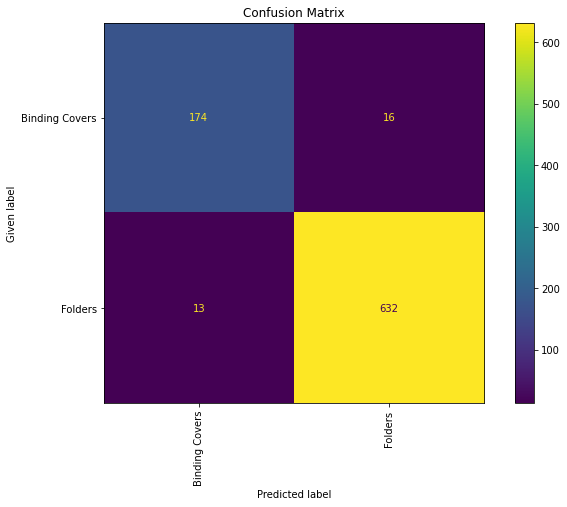

In [7]:
cm = confusion_matrix(y_true=y_given, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(11, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("Given label")
ax.set_xticklabels(label_encoder.classes_, rotation=90, ha='center');

In [8]:
for i in range(psx.shape[0]):
    confident_joint, likely_mislabelled_indices = compute_confident_joint(
        s=y_given,
        psx=psx[i,:],
        calibrate=False,
        return_indices_of_off_diagonals=True
    )
    off_diagonal_sum = np.sum(confident_joint) - np.trace(confident_joint)
#     if off_diagonal_sum > 0:
#         print(f"Confident Joint for iteration {i}")
#         print(confident_joint)
#         print(off_diagonal_sum)
    

In [9]:
likely_mislabelled_indices

array([232, 399, 467])

In [10]:
for class_index, class_name in enumerate(label_encoder.classes_):
    df_data[f"Pred Proba {class_name}"] = psx[0, :, class_index]
df_data["Given Label"] = df_data["category_name"]
y_pred = np.argmax(psx[0], axis=1)
df_data["Pred Label"] = [label_encoder.classes_[c] for c in y_pred]
df_data["Mislabelled"] = df_data["Given Label"] != df_data["Pred Label"]
df_data["CL: Likely Mislabelled"] = False
df_data.loc[df_data.iloc[likely_mislabelled_indices].index.tolist(), "CL: Likely Mislabelled"] = True

col_unique_counts = df_data.nunique(axis=0)
nan_column_names = col_unique_counts[col_unique_counts == 0].index.tolist()
valid_columns = [c for c in df_data.columns if c not in nan_column_names]
df_data[valid_columns].to_excel('mislabelled.xlsx')

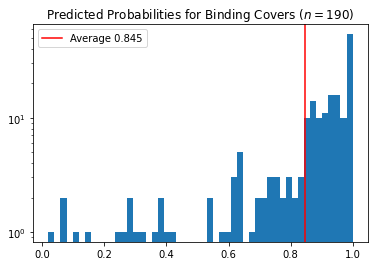

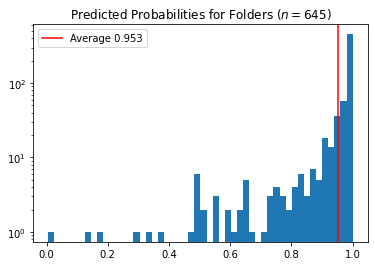

In [11]:
for class_index in np.unique(y_given):
    class_name = label_encoder.classes_[class_index]
    
    class_sample_indices = np.where(df_data.category_name == class_name)[0]
    n_samples = len(class_sample_indices)
    fig, ax = plt.subplots()
    class_probas = psx[0, class_sample_indices, class_index]
    mean_proba = class_probas.mean()
    
    ax.hist(psx[0, class_sample_indices, class_index], bins=50)
    ax.axvline(x=mean_proba, color="red", label=f"Average {mean_proba:0.3f}")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(f"Predicted Probabilities for {class_name} ($n={n_samples}$)");

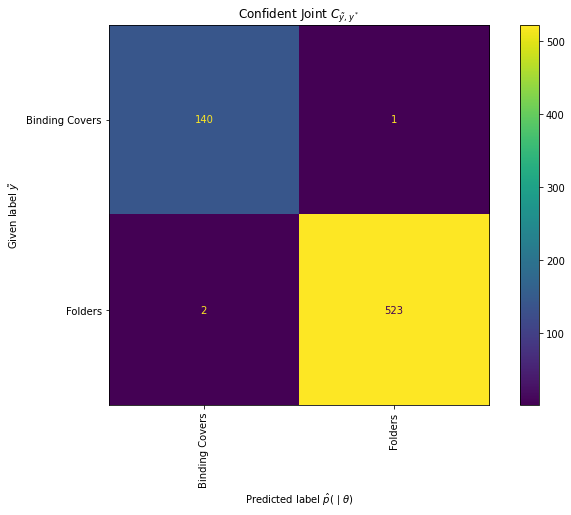

In [12]:
fig, ax = plt.subplots(figsize=(11, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=confident_joint, display_labels=label_encoder.classes_)
disp.plot(ax=ax)
ax.set_title("Confident Joint $C_{\\tilde{y}, y^*}$")
ax.set_ylabel("Given label $\\tilde{y}$")
ax.set_xlabel("Predicted label $\\hat{p}(\\mid \\theta)$")
ax.set_xticklabels(label_encoder.classes_, rotation=90, ha='center');


In [13]:
py, noise_matrix, inv_noise_matrix = estimate_latent(
    confident_joint=confident_joint,
    s=y_given,
    py_method='cnt',
    converge_latent_estimates=False,
)

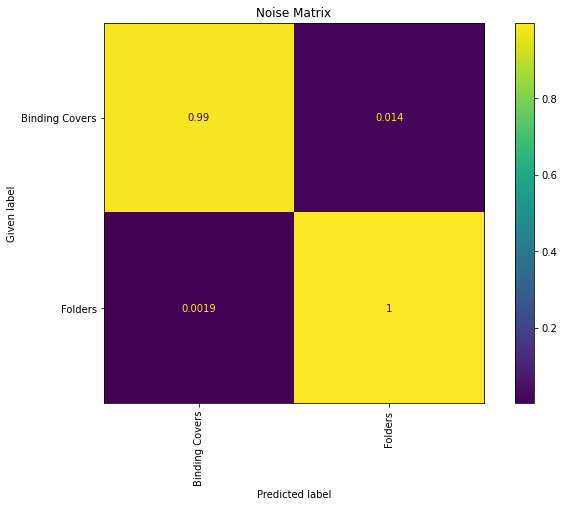

In [14]:
fig, ax = plt.subplots(figsize=(11, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=noise_matrix.T, display_labels=label_encoder.classes_)
disp.plot(ax=ax)
ax.set_title("Noise Matrix")
ax.set_ylabel("Given label")
ax.set_xticklabels(label_encoder.classes_, rotation=90, ha='center');


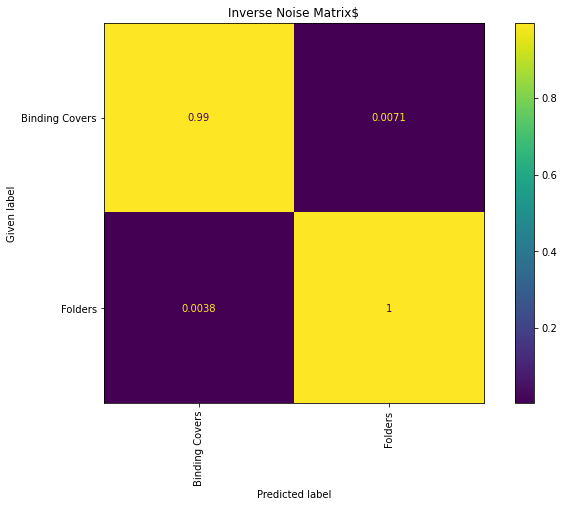

In [15]:
fig, ax = plt.subplots(figsize=(11, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=inv_noise_matrix.T, display_labels=label_encoder.classes_)
disp.plot(ax=ax)
ax.set_title("Inverse Noise Matrix$")
ax.set_ylabel("Given label")
ax.set_xticklabels(label_encoder.classes_, rotation=90, ha='center');
